# HMM

Для повышения точности прогнозов важно понимать, что разные модели прогнозирования подходят для разных временных рядов с разными характеристиками.
        
При описании временных рядов регрессионными моделями обычно предполагается, что параметры моделей не изменяются на интервале наблюдения. Вместе с тем, например, экономические временные ряды часто демонстрируют нестационарное поведение, которое может быть обусловлено экономическими спадами, финансовыми кризисами, технологическими изменениями, положительными и отрицательными новостями и другими событиями. 

Если изменения
происходят в случайные моменты времени, то для адекватного описания могут быть использованы модели со скачкообразными изменениями параметров и с переключениями режимов работы


HMMlearn - библиотека с открытым исходным кодом, которая состоит из простых алгоритмов и моделей для изучения скрытых марковских моделей (HMM) в Python

In [3]:
pip install hmmlearn

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set()

# Модели временных рядов с переключениями

Обозначим $s_t$ ненаблюдаемую переменную состояния, принимающую значения 0 или 1. Простейшая модель переключения для переменной $z_t$ состоит из двух спецификаций типа AR:

$z_t = \begin{cases} \alpha_0 + \beta z_{t-1} + \epsilon_t, & s_t = 0 \\ \alpha_0 + \alpha_1 + \beta z_{t-1} + \epsilon_t, & s_t = 1 \end{cases}$
 
где $|\beta|<1$ и $\epsilon_t$ независимые одинаково распределённые случайные величины с нулевым средним и дисперсией $\sigma^2_\epsilon$.

In [6]:
eps = np.random.normal(size=100)
alpha_0 = 0.
alpha_1 = 1.
beta = .05
s = np.random.binomial(n=1, p=0.8, size=100)
z1 = alpha_0 + beta * eps
z2 = alpha_0 + alpha_1 + beta * eps

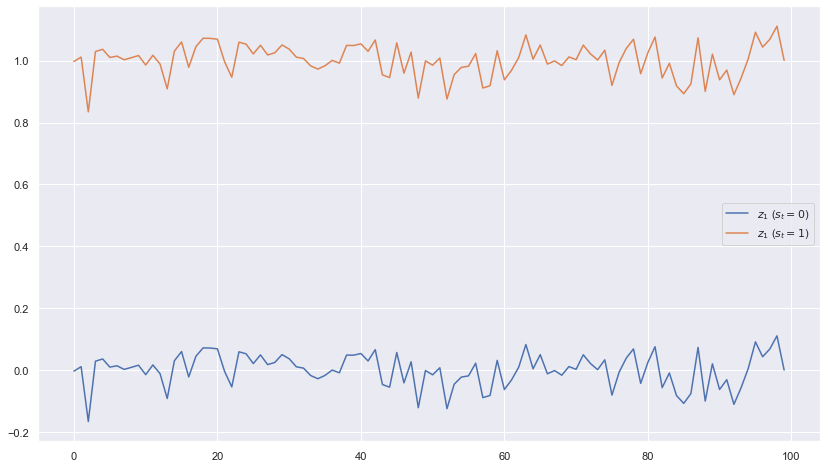

In [7]:
plt.figure(figsize=(14,8))
plt.plot(z1, label='$z_1$ ($s_t = 0$)')
plt.plot(z2, label='$z_1$ ($s_t = 1$)')
plt.legend()
plt.show()

In [8]:

z = []
for t, s_t in enumerate(s):
    if s_t == 0:
        z.append(z1[t])
    else:
        z.append(z2[t])

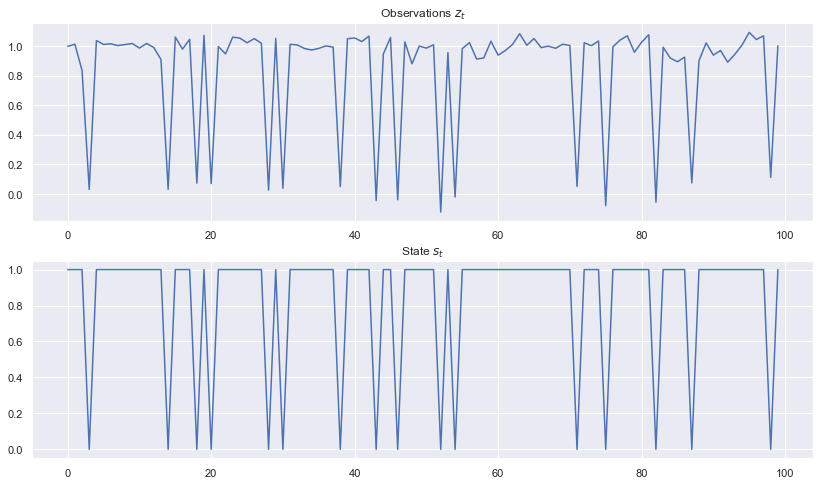

In [9]:
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
axs[0].plot(z)
axs[0].set_title('Observations $z_t$')
axs[1].plot(s)
axs[1].set_title('State $s_t$')
plt.show()

Это стационарный AR(1) процесс со средним $\dfrac{\alpha_0}{1-\beta}$ при $s_t=0$ и переключающийся на другой стационарный AR(1) процесс со средним $\dfrac{\alpha_0+\alpha_1}{1-\beta}$, когда $s_t$ переключается с 0 на 1.

- если $a_1 \ne 0$: два динамических паттерна в зависимости от значения переменной состояния $s_t$;
- в этом случае $z_t$ управляется двумя распределениями с разным средним;
- переменная $s_t$ отвечает за переключение между этими распределениями (режимами).

Только что показанный пример: $s_t \sim Bern(p),p=0.8$.

В этой модели $s_t$ не зависит от предыдущих и будущих реализаций, поэтому $z_t$ может сильно "прыгать" (часто переключаться между разными состояниями).

## Что такое модель с марковским переключением?

Пусть, как раньше,

$z_t = \begin{cases} \alpha_0 + \beta z_{t-1} + \epsilon_t, & s_t = 0 \\ \alpha_0 + \alpha_1 + \beta z_{t-1} + \epsilon_t, & s_t = 1 \end{cases}$

Обозначим $s_t$ ненаблюдаемую переменную состояния, принимающую значения 0 или 1 согласно марковской цепи первого порядка:

$P=\begin{pmatrix} P(s_t=0|s_{t-1}=0) & P(s_t=1|s_{t-1}=0 \\ P(s_t=0|s_{t-1}=1) & P(s_t=1|s_{t-1}=1 \end{pmatrix} = \begin{pmatrix} p_{00} & p_{01} \\ p_{10} & p_{11} \end{pmatrix}$

где за $p_{ij},i,j∈\{0,1\}$ обозначена вероятность перехода в состояние $s_t=j$ из состояния $s_{i−1}=i$.

- Матрица перехода управляет случайным поведением переменной состояния и зависит только от двух параметров ($p00$
 и $p11$).
- Модель такого типа называют моделью с марковскими переключениями.
- Свойства $z_t$ определяются характеристиками распределения как $\epsilon_t$, так и переменной состояния $s_t$.
- В частности, марковская переменная состояния приводит к случайным и частым сменам режима, а вероятности перехода определяют персистентность каждого из режимов.

Важный факт: распределение наблюдений обусловлено ненаблюдаемой переменной состояния:
$Law(z_t)=Law(z_t|s_t)$

Например:
- $Law(z_t|s_t=0) = N(\dfrac{\alpha_0}{1-\beta}, \sigma_\epsilon^2)$
- $Law(z_t|s_t=1) = N(\dfrac{\alpha_0 + \alpha_1}{1-\beta}, \sigma_\epsilon^2)$

# Как сгенерировать траекторию модели с марковскими переключениями?

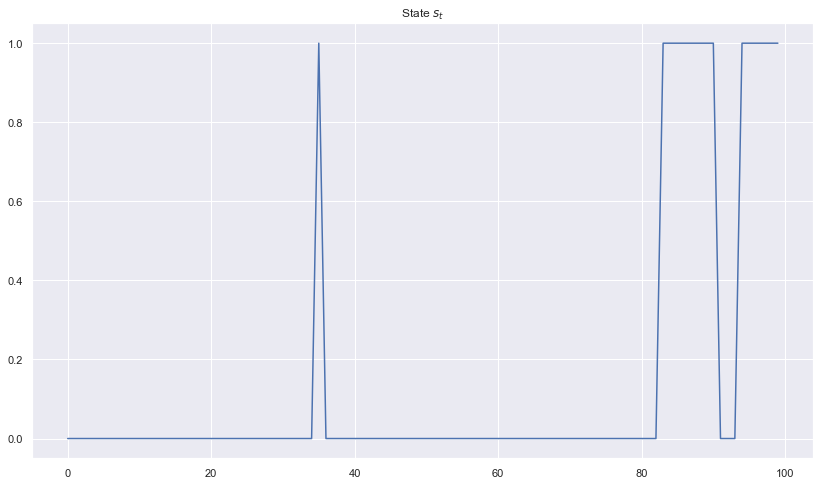

In [10]:
# 1. Генерирование марковской цепи с 2 скрытыми состояниями
P = np.array([
    [0.95, 0.05],
    [0.05, 0.95],
])
s = [0]
for t in range(99):
    distribution = P[s[-1]]
    s.append(np.random.choice([0, 1], p=distribution))

f, axs = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
axs.plot(s)
axs.set_title('State $s_t$')
plt.show()

In [11]:
# 2. Генерирование наблюдений из распределений, обусловленных ненаблюдаемым состоянием
eps = np.random.normal(size=100)
alpha_0 = 0.
alpha_1 = 1.
beta = .05
z1 = alpha_0 + beta * eps
z2 = alpha_0 + alpha_1 + beta * eps
z = []
for t, s_t in enumerate(s):
    if s_t == 0:
        z.append(z1[t])
    else:
        z.append(z2[t])

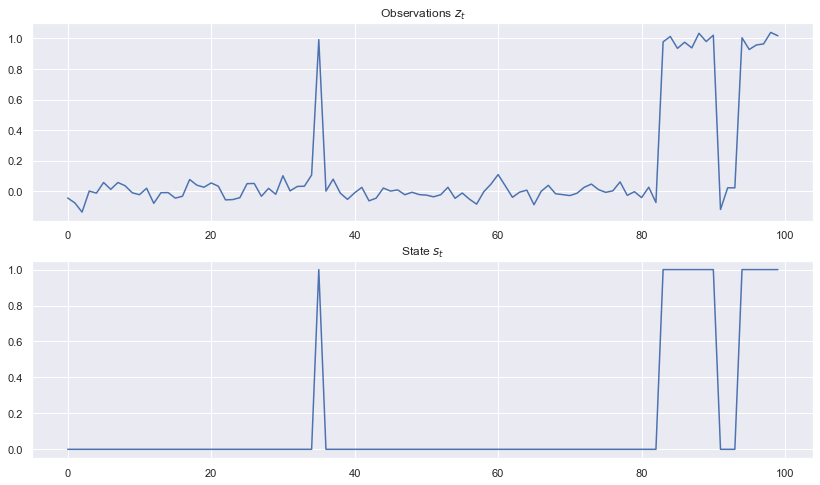

In [12]:
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
axs[0].plot(z)
axs[0].set_title('Observations $z_t$')
axs[1].plot(s)
axs[1].set_title('State $s_t$')
plt.show()

Основные задачи теории скрытых марковских процессов:
    
- **Обучение с учителем**. Пусть есть некоторая последовательность $X$, для которой известны латентные переменные $T$. По обучающей выборке нужно оценить набор параметров $\Theta$.
- **Сегментация**. Пусть известна последовательность наблюдаемых переменных $X$ и набор параметров $\Theta$. По ним нужно построить максимально правдоподобный набор латентных переменных $T$, то есть найти $argmax_T p(T∣X,\Theta)$.
- **Обучение без учителя**. Пусть известна последовательность наблюдаемых переменных $X$ и число состояний $K$. Нужно оценить набор параметров $\Theta$. Подзадача - **нахождение маргинального распределения**: найти $p(t_n∣X,\Theta)$.
- **Прогнозирование**. Пусть известна некоторая последовательность X длины N. Нужно оценить наблюдаемый вектор в момент времени $N+1$, то есть найти $p(x_{N+1}∣X)$.

# Как сгенерировать траекторию скрытой марковской модели?

In [13]:
import numpy as np
from hmmlearn import hmm
np.random.seed(42)

model = hmm.GaussianHMM(n_components=3, covariance_type="full")
model.startprob_ = np.array([0.6, 0.3, 0.1])
model.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.3, 0.5, 0.2],
                            [0.3, 0.3, 0.4]])
model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
model.covars_ = np.tile(np.identity(2), (3, 1, 1))
X, Z = model.sample(100)

No handles with labels found to put in legend.


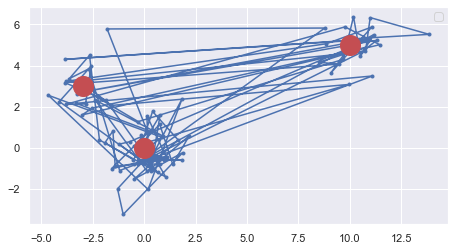

In [14]:
f, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
_ = axs.plot(X[:, 1], X[:, 0], '.-')
_ = axs.plot(model.means_[:, 1], model.means_[:, 0], 'ro', ms=20)
_ = axs.legend()
axs.set_aspect('equal')

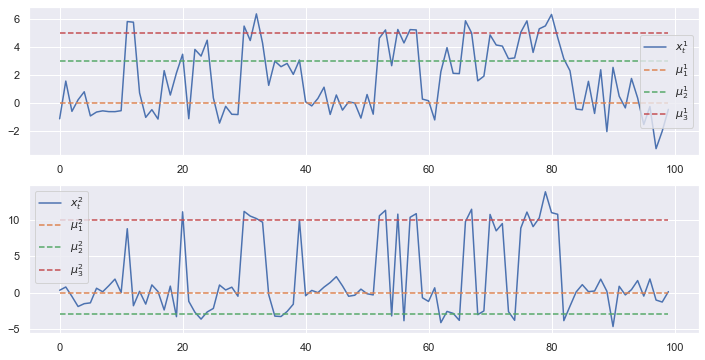

In [15]:
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
_ = axs[0].plot(X[:, 0], label='$x^1_t$')
for i in range(3):
    _ = axs[0].plot(range(len(X)), model.means_[i, 0] * np.ones(len(X)), '--', label='$\mu^1_{}$'.format(i+1))
_ = axs[0].legend()

_ = axs[1].plot(X[:, 1], label='$x^2_t$')
for i in range(3):
    _ = axs[1].plot(range(len(X)), model.means_[i, 1] * np.ones(len(X)), '--', label='$\mu^2_{}$'.format(i+1))
_ = axs[1].legend()

# Прогноз с использованием HMM

Загрузка скрытого гауссовского класса модели Маркова

In [16]:
from hmmlearn.hmm import GaussianHMM

In [19]:
series = pd.read_csv("DUQ_hourly.csv")["DUQ_MW"]

In [21]:
series

0         1458.0
1         1377.0
2         1351.0
3         1336.0
4         1356.0
5         1372.0
6         1402.0
7         1425.0
8         1502.0
9         1556.0
10        1603.0
11        1615.0
12        1617.0
13        1630.0
14        1619.0
15        1613.0
16        1683.0
17        1764.0
18        1786.0
19        1737.0
20        1726.0
21        1669.0
22        1592.0
23        1493.0
24        1484.0
25        1419.0
26        1378.0
27        1359.0
28        1375.0
29        1437.0
           ...  
119038    2096.0
119039    2070.0
119040    2048.0
119041    1988.0
119042    1889.0
119043    1781.0
119044    1704.0
119045    1663.0
119046    1633.0
119047    1619.0
119048    1623.0
119049    1649.0
119050    1675.0
119051    1682.0
119052    1698.0
119053    1731.0
119054    1743.0
119055    1764.0
119056    1784.0
119057    1803.0
119058    1811.0
119059    1828.0
119060    1858.0
119061    1960.0
119062    1968.0
119063    1962.0
119064    1940.0
119065    1891

In [23]:
values = series.values.reshape(-1,1)

In [25]:
values

array([[1458.],
       [1377.],
       [1351.],
       ...,
       [1891.],
       [1820.],
       [1721.]])

Cоздадим  и обучим гауссовский HMM. Функция этого класса требует в качестве входных данных число скрытых состояний, число итераций для запуска из алгоритма Baum-Welch

Первым шагом в прогнозировании является обучение HMM для вычисления параметров из данной последовательности наблюдений. 
Как найти оптимальное количество скрытых состояний?

In [34]:
for n in range(1, 14):
    model = GaussianHMM(n_components=n,
                        
                        n_iter=1000)
    model.fit(values)
    print (n, model.score(values))

1 -848776.4967285757
2 -805638.2251340441
3 -771856.8638826762
4 -751347.3880048137
5 -735193.0759745217
6 -724393.8407221357
7 -715557.7724818655
8 -709212.6570854799
9 -704268.6809619613
10 -699827.1148733359
11 -696170.9874747912
12 -693158.1775784098
13 -690397.0611685034


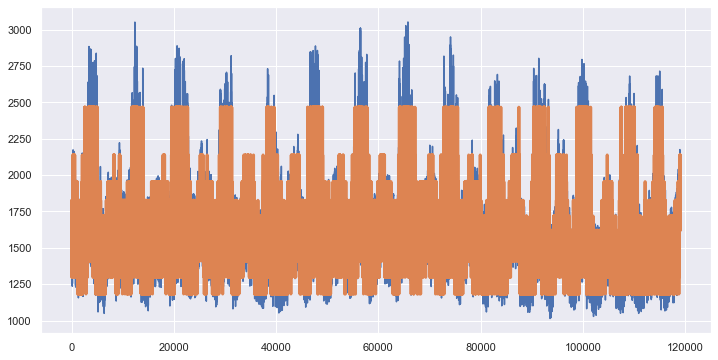

In [35]:
model = GaussianHMM(n_components=10,
                        covariance_type="diag",
                        n_iter=1000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)

In [36]:
model.transmat_.shape

(10, 10)

In [37]:
print(model.transmat_)

[[5.82328923e-001 2.02783813e-022 8.14457887e-005 0.00000000e+000
  5.71118528e-003 2.52132938e-001 0.00000000e+000 3.82033362e-004
  1.54895006e-001 4.46846833e-003]
 [1.25184544e-003 6.67991795e-001 8.58158693e-003 0.00000000e+000
  9.53997201e-264 5.24593780e-003 1.24896060e-001 1.86302078e-001
  3.20247087e-004 5.41044988e-003]
 [5.65900395e-003 1.59380863e-003 6.12687358e-001 0.00000000e+000
  2.85894381e-005 1.49959129e-002 6.59320271e-005 1.75478247e-001
  1.04662337e-003 1.88444524e-001]
 [2.51106990e-162 1.77062071e-004 7.72973542e-004 8.80523148e-001
  0.00000000e+000 2.32659996e-004 1.16810130e-001 1.48402703e-003
  0.00000000e+000 2.07725151e-111]
 [8.86537854e-084 0.00000000e+000 0.00000000e+000 0.00000000e+000
  8.00342051e-001 0.00000000e+000 0.00000000e+000 0.00000000e+000
  1.99657949e-001 0.00000000e+000]
 [1.83539677e-001 1.30430181e-004 1.35017460e-002 0.00000000e+000
  2.14408230e-003 5.62652534e-001 1.29748410e-150 3.84216088e-006
  1.01659735e-002 2.27861715e-001